# Classifiers in Sklearn

In [264]:
import time
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt                             

from sklearn.datasets import make_moons
from   sklearn.model_selection import train_test_split, cross_validate, cross_val_score

#---------------------------------------------------------------------------------------

def generate_xor(num = 50):
    X1 = np.random.normal( [0.2,0.2], 0.1, (num,2)).clip(0,1);  Y1 = np.full((num,), 0)   
    X2 = np.random.normal( [0.8,0.2], 0.1, (num,2)).clip(0,1);  Y2 = np.full((num,), 1)   
    X3 = np.random.normal( [0.8,0.8], 0.1, (num,2)).clip(0,1);  Y3 = np.full((num,), 0)   
    X4 = np.random.normal( [0.2,0.8], 0.1, (num,2)).clip(0,1);  Y4 = np.full((num,), 1)   
    return np.concatenate([X1,X2,X3,X4], axis=0),  np.concatenate([Y1,Y2,Y3,Y4], axis=0)

#---------------------------------------------------------------------------------------

def two_blobs(num = 100):
    X1 = np.random.normal( [0.3,0.7], 0.2, (num,2)).clip(0,1);  Y1 = np.full((num,), 0)
    X2 = np.random.normal( [0.7,0.3], 0.2, (num,2)).clip(0,1);  Y2 = np.full((num,), 1)
    return np.concatenate([X1,X2], axis=0),  np.concatenate([Y1,Y2], axis=0)

#---------------------------------------------------------------------------------------

def eval_model(clf, X,Y, CV=20, prob = True):
    tm1 = time.process_time() 
    res = cross_validate(clf, X, Y, cv=CV, return_train_score=True)            
    tm2 = time.process_time() 
    clf.fit(X,Y)
    probs = clf.predict_proba(X)  if prob else [[0, 0]]
    probs = np.max(probs, axis=1)
    print(f"val: {res['test_score'].mean():.3f} ± {res['test_score'].std()/len(res)**0.5:.3f}    trn: {res['train_score'].mean():.3f} ± {res['train_score'].std()/len(res)**0.5:.3f}  probs: {probs.mean():.3f} ± {probs.std():.3f}    {(tm2-tm1)/CV:.2f}s")

#---------------------------------------------------------------------------------------
    
def plot_data(X, Y, lim=(0.,1.), clf = None, num = 100, prob = True, title=""):                
    x1 = np.linspace(lim[0], lim[1], num, dtype=np.float32)
    x2 = np.linspace(lim[0], lim[1], num, dtype=np.float32)
    x1, x2 =  np.meshgrid(x1, x2)    

    plt.figure (figsize=(4, 4), facecolor ='w')                                 
    
    if clf is not None:   
        inp = np.c_[x1.ravel(), x2.ravel()]
        if prob:
            prob = clf.predict_proba(inp)[:,1].reshape(x1.shape)
            plt.imshow(prob, extent=[lim[0], lim[1], lim[0], lim[1]],  origin='lower', cmap='bwr', alpha=0.3)
            
            label = clf.predict(inp).reshape(x1.shape) 
            plt.contour(x1, x2, label, cmap='gray')                
        else:        
            label = clf.predict(inp).reshape(x1.shape) 
            plt.contourf(x1, x2, label, alpha=0.3, cmap='bwr')                
    
    plt.scatter(X[:,0], X[:,1], c=Y,  s=5, cmap='bwr')        
    plt.xlim(0, 1)
    plt.ylim(0, 1);
    plt.title(title)
    plt.show()                                                  

## Create Data

In [257]:
#X, Y = generate_xor(num = 150)
X, Y = two_blobs(num = 250)
#X, Y = make_moons(n_samples=500, noise=0.1, random_state=53)

X = (X - X.min(axis=0))/(X.max(axis=0)-X.min(axis=0))
print(X.shape, Y.shape)
#plot_data(X,Y)

(500, 2) (500,)


## LogisticRegression

val: 0.912 ± 0.036    trn: 0.912 ± 0.002  probs: 0.856 ± 0.131    0.02s


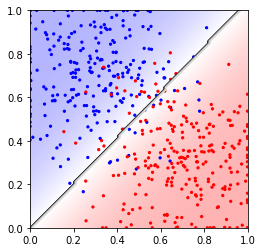

In [258]:
from sklearn.linear_model    import LogisticRegression

clf = LogisticRegression(C=1)   # C - inverse of regularization strength (smaller values specify stronger regularization)

eval_model(clf, X,Y)
plot_data(X, Y, clf = clf, prob = True)     

## KNeighbors

val: 0.908 ± 0.032    trn: 0.913 ± 0.002  probs: 0.908 ± 0.131    0.03s


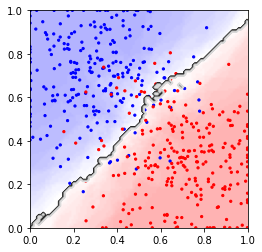

In [260]:
from sklearn.neighbors       import KNeighborsClassifier

class CFG:        
    n_neighbors = 30   

clf = KNeighborsClassifier(n_neighbors = CFG.n_neighbors)

eval_model(clf, X,Y)
plot_data(X, Y, clf = clf, prob = True)  

## SVM

val: 0.906 ± 0.034    trn: 0.912 ± 0.002  probs: 0.000 ± 0.000    0.02s


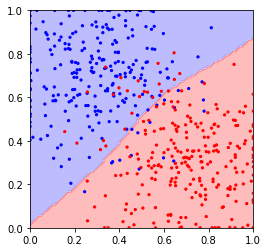

In [261]:
from sklearn.svm import LinearSVC, SVC, NuSVC

clf = SVC()

eval_model(clf, X,Y, prob = False)
plot_data(X, Y, clf = clf, prob = False)

## DecisionTree

✅ Деревья решений лучше других методов, когда расстояние между точками в прострастве прихнаков особого смысла не имеет (разделение только по одному признаку).<br>
✅ Деревья не требуют масштабирования или центрирования признаков.<br>

val: 0.866 ± 0.043    trn: 0.942 ± 0.002  probs: 0.946 ± 0.115    0.00s
depth: 9


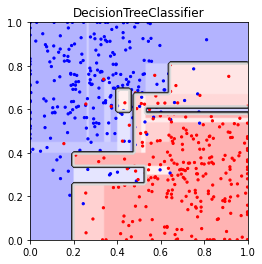

In [265]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

class CFG:        
    min_samples_leaf = 5       # Def:1
    min_samples_split= 2       # Def:2
    max_depth        = None    # Def:None

clf = DecisionTreeClassifier(max_depth=CFG.max_depth, min_samples_split=CFG.min_samples_split, min_samples_leaf=CFG.min_samples_leaf)
#clf = DecisionTreeClassifier()

eval_model(clf, X,Y)
print(f"depth: {clf.get_depth()}")
plot_data(X, Y, clf = clf, title="DecisionTreeClassifier")     

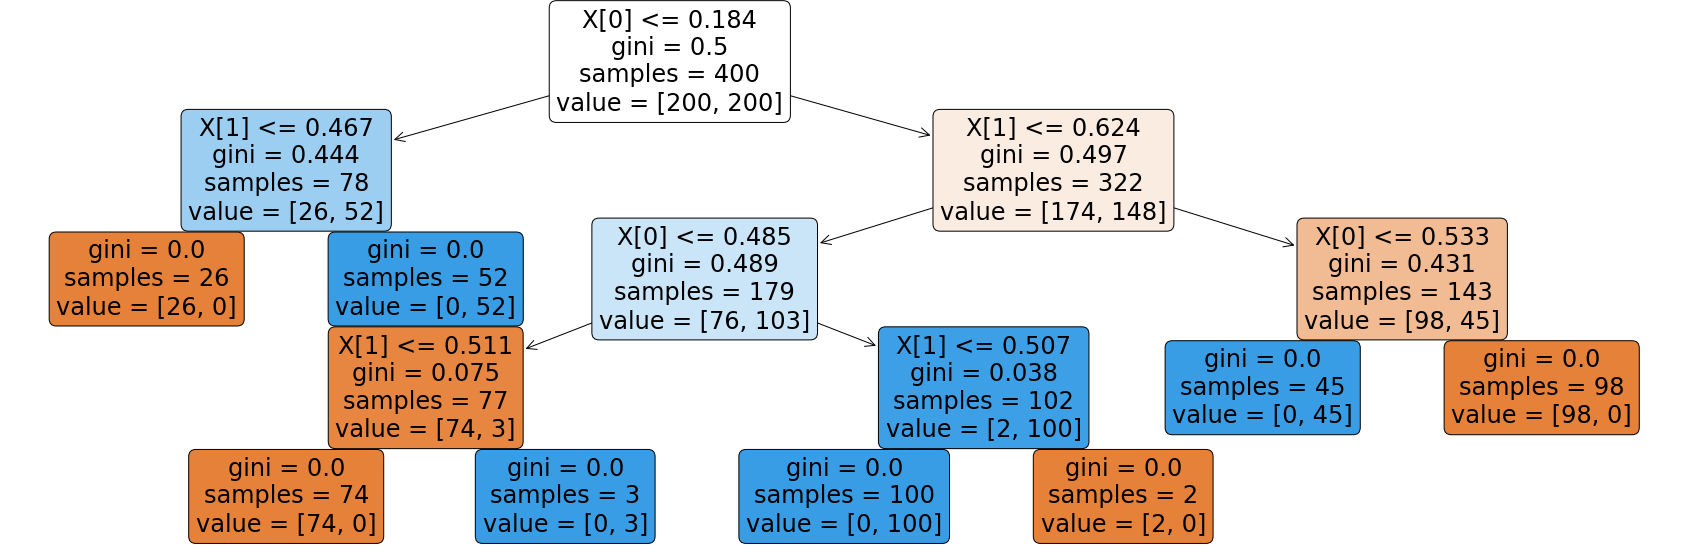

In [204]:
clf = DecisionTreeClassifier()
clf.fit(X,Y)
plt.figure(figsize=(30, 10), facecolor ='w')     
tree.plot_tree(clf,   max_depth=4,  filled=True, fontsize=24, rounded=True) # feature_names=COLUMNS,
plt.show()

##  RandomForest

val: 0.906 ± 0.033    trn: 0.919 ± 0.003  probs: 0.865 ± 0.148    0.25s


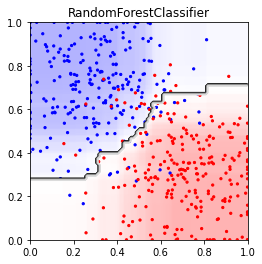

In [266]:
from sklearn.ensemble import RandomForestClassifier

class CFG:    
    n_estimators     = 100
    min_samples_leaf = 20
    max_depth        = None
    
clf = RandomForestClassifier(n_estimators=CFG.n_estimators, max_depth=CFG.max_depth, min_samples_leaf=CFG.min_samples_leaf)
#clf = DecisionTreeClassifier()

eval_model(clf, X,Y)
plot_data(X, Y, clf = clf, title="RandomForestClassifier")         

In [ ]:
clf = RandomForestClassifier(n_estimators=CFG.n_estimators, max_depth=CFG.max_depth, min_samples_leaf=CFG.min_samples_leaf)
clf.fit(X,Y)
plt.figure(figsize=(30, 10), facecolor ='w')     
tree.plot_tree(clf,   max_depth=4,  filled=True, fontsize=24, rounded=True) # feature_names=COLUMNS,
plt.show()

# Ансамбли моделей

## Bag Ensemble

val: 0.902 ± 0.035    trn: 0.919 ± 0.003  probs: 0.865 ± 0.149    0.25s


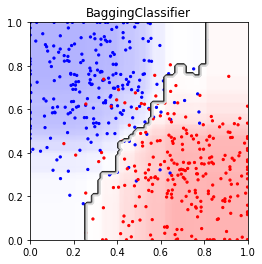

In [268]:
from sklearn.ensemble import BaggingClassifier

bag = BaggingClassifier(LogisticRegression(max_iter=1000),  
                        max_samples=0.5, max_features=0.8)

eval_model(clf, X,Y)
plot_data(X, Y, clf = clf, title="BaggingClassifier")         

## AdaBoost

## GradientBoostingClassifier

val: 0.854 ± 0.032    trn: 1.000 ± 0.000  probs: 1.000 ± 0.000    0.68s


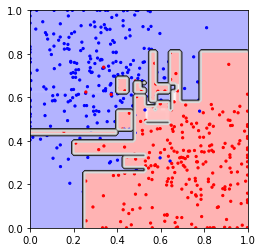

In [263]:
from sklearn.ensemble import GradientBoostingClassifier

class CFG:    
    n_estimators = 300
    max_depth    = 30

clf = GradientBoostingClassifier(n_estimators=CFG.n_estimators, max_depth=CFG.max_depth, random_state=0)

eval_model(clf, X,Y)
plot_data(X, Y, clf = clf, title="GradientBoostingClassifier")     

## CatBoost

val: 0.996 ± 0.006    trn: 1.000 ± 0.000  probs: 0.995 ± 0.004    9.06s


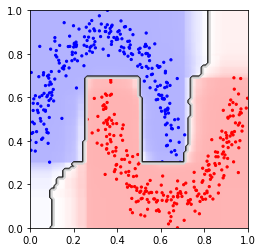

In [252]:
from catboost import CatBoostClassifier

class CFG: 
    """ https://docs.aws.amazon.com/sagemaker/latest/dg/catboost-tuning.html """
    max_depth       = 10       # Valid:int[1,16], Def:6     Grid:[4,10]        > Depth of the tree
    l2_leaf_reg     = 100       # Valid:int>0,    Def:3     Grid:[2,10]        > Coefficient for the L2 regularization term of the cost function.
    random_strength = 1       # Valid:float>0     Def:1     Grid:[0,10]        > The amount of randomness to use for scoring splits when the tree structure is selected. Use this parameter to avoid overfitting the model.
    learning_rate   = 0.1     # Valid:float[0,1]  Def:0.009 Grid:[0.001, 0.01] > The rate at which the model weights are updated after working through each batch of training examples (0,1) 
    iterations      = 500     #                   Def:500   Grid:[]            > The maximum number of trees that can be built    

clf = CatBoostClassifier(iterations=CFG.iterations, learning_rate=CFG.learning_rate, l2_leaf_reg=CFG.l2_leaf_reg, random_strength=CFG.random_strength, verbose=0)        
eval_model(clf, X,Y)
plot_data(X, Y, clf = clf)     

## LightGBM

val: 0.982 ± 0.015    trn: 1.000 ± 0.000  probs: 0.991 ± 0.005


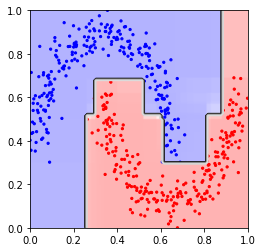

In [233]:
import lightgbm as lgb

class CFG:
    method          = 'lgb'          #
    tree_type       = 'dart'         # Def:'gbdt'   Val:('dart' 'gbdt' 'goss')
    
    n_estimators    = 200            # Def:100
    learning_rate   = 0.1            # Def:0.1
            
    # Это очень важный параметр для предотвращения чрезмерной подгонки в листовом дереве.
    # Его оптимальное значение зависит от количества обучающих выборок и num_leaves
    #min_data_in_leaf = 100
    
    max_depth     = -1
    
    ensemble      = 13
    
clf = lgb.LGBMClassifier(boosting_type=CFG.tree_type,  learning_rate=CFG.learning_rate)
eval_model(clf, X,Y)
plot_data(X, Y, clf = clf)     